In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import powerlaw
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch.utils.data import Dataset, DataLoader

# Load dataset
file_path = "data/nba_player_interactions_2001_2025.csv"
df = pd.read_csv(file_path)
df = df[df['EVENTMSGTYPE'] == 1]

def get_team_info(game_df, id):
    if np.isnan(id):
        return '', ''
    
    team_info = game_df[game_df['PLAYER1_TEAM_ID'] == id][['PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION']]
    return team_info.iloc[0]['PLAYER1_TEAM_NICKNAME'], team_info.iloc[0]['PLAYER1_TEAM_ABBREVIATION']

def get_game_winner(game_df):
    game_df = game_df.sort_values(by='EVENTNUM')
    left_team, right_team = -1, -1
    left_team_name, left_team_abbre, right_team_name, right_team_abbre = '', '', '', ''
    team_ids = set(game_df['PLAYER1_TEAM_ID'].values)

    idx = 0
    while True:
        if game_df.iloc[idx]['SCOREMARGIN'] == 'TIE':
            idx += 1
        else:
            break
    first_score = game_df.iloc[idx]['SCORE']
    first_score_parts = first_score.split('-')
    first_score_left = int(first_score_parts[0].strip())
    first_score_right = int(first_score_parts[1].strip())

    if first_score_left > first_score_right:
        left_team = game_df.iloc[idx]['PLAYER1_TEAM_ID']
        left_team_name, left_team_abbre = get_team_info(game_df, left_team)
        right_team = list(team_ids - set([left_team]))[0]
        right_team_name, right_team_abbre = get_team_info(game_df, right_team)
    else:
        right_team = game_df.iloc[idx]['PLAYER1_TEAM_ID']
        right_team_name, right_team_abbre = get_team_info(game_df, right_team)        
        left_team = list(team_ids - set([right_team]))[0]
        left_team_name, left_team_abbre = get_team_info(game_df, left_team)
    
    final_score = game_df.iloc[-1]['SCORE']
    final_score_parts = final_score.split('-')
    final_score_left = int(final_score_parts[0].strip())
    final_score_right = int(final_score_parts[1].strip())
    
    if final_score_left > final_score_right:
        result = {
            'tie': False,
            'winner_team_id': left_team,
            'winner_team_name': left_team_name,
            'winner_team_abbre': left_team_abbre,
            'winner_score': final_score_left,
            'loser_team_id': right_team,
            'loser_team_name': right_team_name,
            'loser_team_abbre': right_team_abbre,
            'loser_score': final_score_right
        }
    elif final_score_left < final_score_right:
        result = {
            'tie': False,
            'winner_team_id': right_team,
            'winner_team_name': right_team_name,
            'winner_team_abbre': right_team_abbre,
            'winner_score': final_score_right,
            'loser_team_id': left_team,
            'loser_team_name': left_team_name,
            'loser_team_abbre': left_team_abbre,
            'loser_score': final_score_left
        }
    else:
        result = {
            'tie': True,
            'winner_team_id': left_team,
            'winner_team_name': left_team_name,
            'winner_team_abbre': left_team_abbre,
            'winner_score': final_score_left,
            'loser_team_id': right_team,
            'loser_team_name': right_team_name,
            'loser_team_abbre': right_team_abbre,
            'loser_score': final_score_right
        }
    return result

def construct_graph_per_game(sub_game_df):
    G = nx.DiGraph()
    for _, row in sub_game_df.iterrows():
        passer = row['PLAYER2_ID']
        scorer = row['PLAYER1_ID']
        if passer == 0:
            continue
        if G.has_edge(passer, scorer):
            G[passer][scorer]['weight'] += 1
        else:
            G.add_edge(passer, scorer, weight=1)
    
    # Normalize edge weights so they sum to 1
    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    if total_weight > 0:
        for u, v, data in G.edges(data=True):
            data['weight'] = data['weight'] / total_weight
    assert math.isclose(sum([data['weight'] for _, _, data in G.edges(data=True)]), 1, rel_tol=1e-4)
    return G

# ---- Convert NetworkX graph to PyG Data object with additional features ----
def nx_to_pyg(G):
    # Compute additional centrality measures
    degree_cent = nx.degree_centrality(G)
    betw_cent = nx.betweenness_centrality(G)
    clos_cent = nx.closeness_centrality(G)
    undirected_clust = nx.clustering(G.to_undirected())

    # Update node features with additional centrality measures
    for node in G.nodes():
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        clust = undirected_clust[node]
        d_cent = degree_cent[node]
        b_cent = betw_cent[node]
        c_cent = clos_cent[node]
        # New feature vector: [in_degree, out_degree, clustering, degree centrality, betweenness centrality, closeness centrality]
        G.nodes[node]['x'] = [in_deg, out_deg, clust, d_cent, b_cent, c_cent]
    
    data = from_networkx(G)
    data.x = data.x.clone().detach().float()
    
    # Compute graph-level features (you can add more if needed)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    data.graph_features = torch.tensor([num_nodes, num_edges, density], dtype=torch.float)
    
    return data


# ---- Define a GNN Encoder (using a simple 2-layer GCN) ----
class GNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        # Global mean pooling to get a graph-level embedding
        x = global_mean_pool(x, batch)
        return x

# ---- Siamese Network for Graph-Level Binary Classification (Two-Output Version) ----
class SiameseGNN(nn.Module):
    def __init__(self, encoder, embed_dim, graph_feat_dim, hidden_dim):
        super(SiameseGNN, self).__init__()
        self.encoder = encoder
        # Now, each graph's final representation will be (embed_dim + graph_feat_dim)
        # We combine two such representations (and their absolute difference)
        self.fc1 = nn.Linear((embed_dim + graph_feat_dim) * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # Two outputs for two classes
        
    def forward(self, data1, data2):
        x1 = self.encoder(data1.x, data1.edge_index, data1.batch)
        x2 = self.encoder(data2.x, data2.edge_index, data2.batch)
        # Concatenate graph-level features if present
        if hasattr(data1, 'graph_features'):
            x1 = torch.cat([x1, data1.graph_features], dim=1)
        if hasattr(data2, 'graph_features'):
            x2 = torch.cat([x2, data2.graph_features], dim=1)
        diff = torch.abs(x1 - x2)
        out = torch.cat([x1, diff], dim=1)
        out = F.relu(self.fc1(out))
        logits = self.fc2(out)  # Raw scores for each class
        return logits


# ---- Custom Dataset for Paired Team Graphs ----
class TeamGraphPairDataset(Dataset):
    def __init__(self, samples):
        """
        samples: list of tuples (data_team1, data_team2, label)
        """
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

# Custom collate function to batch pairs of graphs, including graph_features
def collate_fn(batch):
    data1_list, data2_list, labels = zip(*batch)
    batch_data1 = Batch.from_data_list(data1_list)
    batch_data2 = Batch.from_data_list(data2_list)
    # Collate graph-level features if present
    if hasattr(data1_list[0], 'graph_features'):
        batch_data1.graph_features = torch.stack([d.graph_features for d in data1_list])
    if hasattr(data2_list[0], 'graph_features'):
        batch_data2.graph_features = torch.stack([d.graph_features for d in data2_list])
    labels = torch.tensor(labels, dtype=torch.float).view(-1, 1)
    return batch_data1, batch_data2, labels

# ================= Create Training Pairs =================
# For now, using season 2001
#training_df = df[df['Season'].isin(np.arange(2001,2023))]
training_df = df[df['Season'].isin(np.arange(2016,2023))]
valid_df = df[df['Season'] == 2023]
test_df = df[df['Season'] == 2024]


train_unique_games = training_df['Game_ID'].unique()
pairs = []
for game_id in train_unique_games:
    game_df = training_df[training_df['Game_ID'] == game_id]
    team_split_result = get_game_winner(game_df)
    if np.isnan(team_split_result['winner_team_id']) or np.isnan(team_split_result['loser_team_id']):
        continue
    team1, team2 = team_split_result['winner_team_id'], team_split_result['loser_team_id']
    
    team1_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team1])
    team2_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team2])
    data1 = nx_to_pyg(team1_G)
    data2 = nx_to_pyg(team2_G)
    
    pairs.append((data1, data2, 1))  # (winner, loser)
    pairs.append((data2, data1, 0))  # reverse sample


# Create dataset and dataloader
training_dataset = TeamGraphPairDataset(pairs)
dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

here
here
here
here
here
here
here


In [41]:
# ================= Create Validation Pairs =================
valid_pairs = []
valid_unique_games = valid_df['Game_ID'].unique()
for game_id in valid_unique_games:
    game_df = valid_df[valid_df['Game_ID'] == game_id]
    team_split_result = get_game_winner(game_df)
    # Skip if missing team ids
    if np.isnan(team_split_result['winner_team_id']) or np.isnan(team_split_result['loser_team_id']):
        continue
    team1, team2 = team_split_result['winner_team_id'], team_split_result['loser_team_id']
    
    team1_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team1])
    team2_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team2])
    data1 = nx_to_pyg(team1_G)
    data2 = nx_to_pyg(team2_G)
    
    valid_pairs.append((data1, data2, 1))  # (winner, loser)
    valid_pairs.append((data2, data1, 0))  # reverse sample

valid_dataset = TeamGraphPairDataset(valid_pairs)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# ================= Create Test Pairs =================
test_pairs = []
test_unique_games = test_df['Game_ID'].unique()
for game_id in test_unique_games:
    game_df = test_df[test_df['Game_ID'] == game_id]
    team_split_result = get_game_winner(game_df)
    # Skip if missing team ids
    if np.isnan(team_split_result['winner_team_id']) or np.isnan(team_split_result['loser_team_id']):
        continue
    team1, team2 = team_split_result['winner_team_id'], team_split_result['loser_team_id']
    
    team1_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team1])
    team2_G = construct_graph_per_game(game_df[game_df['PLAYER1_TEAM_ID'] == team2])
    data1 = nx_to_pyg(team1_G)
    data2 = nx_to_pyg(team2_G)
    
    test_pairs.append((data1, data2, 1))  # (winner, loser)
    test_pairs.append((data2, data1, 0))  # reverse sample

test_dataset = TeamGraphPairDataset(test_pairs)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [42]:
# ---- Model Setup ----
in_channels = 6       # now using three node features: in-degree, out-degree, clustering coefficient
hidden_channels = 64
embed_dim = 32        # output dimension from the GNN encoder per graph
graph_feat_dim = 3    # we added three graph-level features: num_nodes, num_edges, density
hidden_dim = 32        # hidden layer dimension for classification

encoder = GNNEncoder(in_channels, hidden_channels, embed_dim)
model = SiameseGNN(encoder, embed_dim, graph_feat_dim, hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()


# ---------------- Early Stopping Training Loop ----------------

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_train_loss = 0
    for batch_data1, batch_data2, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data1, batch_data2)
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(dataloader)
    
    # --- Validation ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_data1, batch_data2, labels in valid_loader:
            outputs = model(batch_data1, batch_data2)
            loss = criterion(outputs, labels.squeeze().long())
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(valid_loader)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # save best model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state after training
model.load_state_dict(best_model_state)


Epoch 1: Train Loss = 0.6647, Val Loss = 0.6519
Epoch 2: Train Loss = 0.6526, Val Loss = 0.6444
Epoch 3: Train Loss = 0.6478, Val Loss = 0.6439
Epoch 4: Train Loss = 0.6462, Val Loss = 0.6409
Epoch 5: Train Loss = 0.6440, Val Loss = 0.6523
Epoch 6: Train Loss = 0.6415, Val Loss = 0.6442
Epoch 7: Train Loss = 0.6412, Val Loss = 0.6546
Epoch 8: Train Loss = 0.6415, Val Loss = 0.6378
Epoch 9: Train Loss = 0.6405, Val Loss = 0.6391
Epoch 10: Train Loss = 0.6384, Val Loss = 0.6567
Epoch 11: Train Loss = 0.6393, Val Loss = 0.6382
Epoch 12: Train Loss = 0.6381, Val Loss = 0.6415
Epoch 13: Train Loss = 0.6386, Val Loss = 0.6366
Epoch 14: Train Loss = 0.6377, Val Loss = 0.6365
Epoch 15: Train Loss = 0.6376, Val Loss = 0.6474
Epoch 16: Train Loss = 0.6376, Val Loss = 0.6365
Epoch 17: Train Loss = 0.6370, Val Loss = 0.6400
Epoch 18: Train Loss = 0.6369, Val Loss = 0.6384
Epoch 19: Train Loss = 0.6371, Val Loss = 0.6399
Epoch 20: Train Loss = 0.6366, Val Loss = 0.6318
Epoch 21: Train Loss = 0.6354

KeyboardInterrupt: 

In [43]:
# Load the best model state after training
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [44]:
import os

# Make sure the "models" folder exists
os.makedirs("models", exist_ok=True)

# Save the best model state
torch.save(best_model_state, "models/best_model.pth")
print("Best model saved to models/best_model.pth")

Best model saved to models/best_model.pth


In [48]:
# ---------------- Testing Validation ----------------
model.eval()
all_true_labels = []
all_predictions = []
with torch.no_grad():
    for batch_data1, batch_data2, labels in dataloader:
        outputs = model(batch_data1, batch_data2)
        preds = outputs.argmax(dim=1)  # choose class with highest logit
        all_true_labels.extend(labels.squeeze().tolist())
        all_predictions.extend(preds.tolist())

correct = sum(1 for true, pred in zip(all_true_labels, all_predictions) if true == pred)
accuracy = correct / len(all_true_labels)
print("\n===== Test Set Results (Season 2024) =====")
print("Total Samples Evaluated:", len(all_true_labels))
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


===== Test Set Results (Season 2024) =====
Total Samples Evaluated: 27184
Overall Accuracy: 61.99%


In [45]:
# ---------------- Testing Validation ----------------
model.eval()
all_true_labels = []
all_predictions = []
with torch.no_grad():
    for batch_data1, batch_data2, labels in valid_loader:
        outputs = model(batch_data1, batch_data2)
        preds = outputs.argmax(dim=1)  # choose class with highest logit
        all_true_labels.extend(labels.squeeze().tolist())
        all_predictions.extend(preds.tolist())

correct = sum(1 for true, pred in zip(all_true_labels, all_predictions) if true == pred)
accuracy = correct / len(all_true_labels)
print("\n===== Test Set Results (Season 2024) =====")
print("Total Samples Evaluated:", len(all_true_labels))
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


===== Test Set Results (Season 2024) =====
Total Samples Evaluated: 4380
Overall Accuracy: 61.58%


In [46]:
# ---------------- Testing Test ----------------
model.eval()
all_true_labels = []
all_predictions = []
with torch.no_grad():
    for batch_data1, batch_data2, labels in test_loader:
        outputs = model(batch_data1, batch_data2)
        preds = outputs.argmax(dim=1)  # choose class with highest logit
        all_true_labels.extend(labels.squeeze().tolist())
        all_predictions.extend(preds.tolist())

correct = sum(1 for true, pred in zip(all_true_labels, all_predictions) if true == pred)
accuracy = correct / len(all_true_labels)
print("\n===== Test Set Results (Season 2024) =====")
print("Total Samples Evaluated:", len(all_true_labels))
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


===== Test Set Results (Season 2024) =====
Total Samples Evaluated: 2880
Overall Accuracy: 60.28%


# END

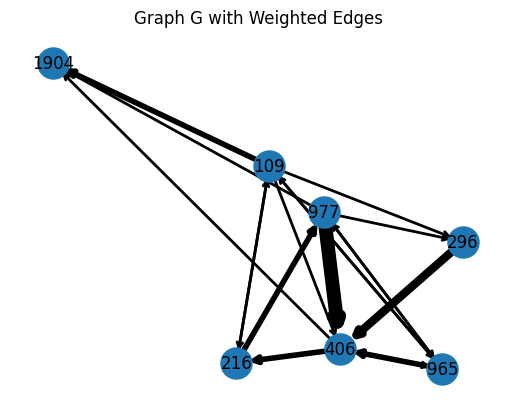

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assume G is your directed graph with a "weight" attribute on each edge
pos = nx.spring_layout(team1_G)  # Compute layout for nodes

# Extract edge widths based on the "weight" attribute; default to 1 if missing
edge_widths = [d.get('weight', 1) for u, v, d in team1_G.edges(data=True)]

# Optionally, you can scale the widths if the weights are small or too large:
scaled_edge_widths = [w * 2 for w in edge_widths]  # Adjust the scaling factor as needed

# Draw the nodes, edges, and labels
nx.draw_networkx_nodes(team1_G, pos, node_size=500)
nx.draw_networkx_edges(team1_G, pos, width=scaled_edge_widths, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(team1_G, pos, font_size=12)

plt.title("Graph G with Weighted Edges")
plt.axis('off')
plt.show()


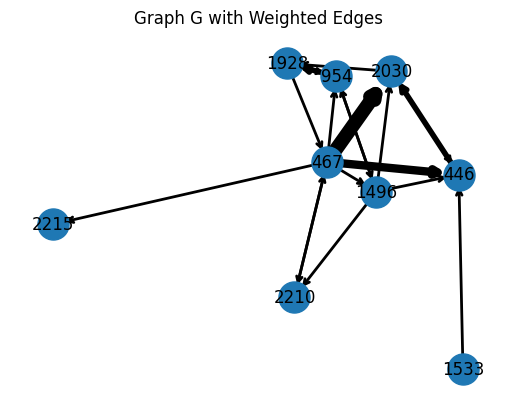

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assume G is your directed graph with a "weight" attribute on each edge
pos = nx.spring_layout(team2_G)  # Compute layout for nodes

# Extract edge widths based on the "weight" attribute; default to 1 if missing
edge_widths = [d.get('weight', 1) for u, v, d in team2_G.edges(data=True)]

# Optionally, you can scale the widths if the weights are small or too large:
scaled_edge_widths = [w * 2 for w in edge_widths]  # Adjust the scaling factor as needed

# Draw the nodes, edges, and labels
nx.draw_networkx_nodes(team2_G, pos, node_size=500)
nx.draw_networkx_edges(team2_G, pos, width=scaled_edge_widths, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(team2_G, pos, font_size=12)

plt.title("Graph G with Weighted Edges")
plt.axis('off')
plt.show()


In [ ]:
def get_team_subgraph(G, team_player_ids):
    # Filter G to include only nodes (players) in the team
    return G.subgraph(team_player_ids).copy()

# Assuming you have a mapping of team IDs to their player IDs for the season:
team_to_players = {
    # Example: team_id: [list of player IDs for that team]
    1610612737: [201939, 202691, 203507],  # Example team and player IDs
    # ... add for all teams in the season
}

team_metrics = {}
for team_id, player_ids in team_to_players.items():
    subG = get_team_subgraph(G, player_ids)
    # Density for a directed graph (using number of possible directed edges)
    num_nodes_team = subG.number_of_nodes()
    num_edges_team = subG.number_of_edges()
    if num_nodes_team > 1:
        density = num_edges_team / (num_nodes_team * (num_nodes_team - 1))
    else:
        density = 0
    
    # Global clustering (transitivity) for directed networks
    clustering = nx.transitivity(subG)
    
    # You can add additional metrics here (e.g., average centrality)
    team_metrics[team_id] = {"density": density, "clustering": clustering}
